In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# for Box-Cox Transformation
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

import meteostat as met
"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
country_wise_df = pd.read_csv('country_wise_latest.csv')

In [5]:
country_wise_df.columns

Index(['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered',
       'Confirmed last week', '1 week change', '1 week % increase',
       'WHO Region'],
      dtype='object')

In [7]:
country_wise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country/Region          187 non-null    object 
 1   Confirmed               187 non-null    int64  
 2   Deaths                  187 non-null    int64  
 3   Recovered               187 non-null    int64  
 4   Active                  187 non-null    int64  
 5   New cases               187 non-null    int64  
 6   New deaths              187 non-null    int64  
 7   New recovered           187 non-null    int64  
 8   Deaths / 100 Cases      187 non-null    float64
 9   Recovered / 100 Cases   187 non-null    float64
 10  Deaths / 100 Recovered  187 non-null    float64
 11  Confirmed last week     187 non-null    int64  
 12  1 week change           187 non-null    int64  
 13  1 week % increase       187 non-null    float64
 14  WHO Region              187 non-null    ob

In [9]:
country_wise_df.describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase
count,1.870000e+02,187.000000,1.870000e+02,1.870000e+02,187.000000,187.000000,187.000000,187.000000,187.000000,187.00,1.870000e+02,187.000000,187.000000
mean,8.813094e+04,3497.518717,5.063148e+04,3.400194e+04,1222.957219,28.957219,933.812834,3.019519,64.820535,inf,7.868248e+04,9448.459893,13.606203
std,3.833187e+05,14100.002482,1.901882e+05,2.133262e+05,5710.374790,120.037173,4197.719635,3.454302,26.287694,NaN,3.382737e+05,47491.127684,24.509838
min,1.000000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,1.000000e+01,-47.000000,-3.840000
25%,1.114000e+03,18.500000,6.265000e+02,1.415000e+02,4.000000,0.000000,0.000000,0.945000,48.770000,1.45,1.051500e+03,49.000000,2.775000
50%,5.059000e+03,108.000000,2.815000e+03,1.600000e+03,49.000000,1.000000,22.000000,2.150000,71.320000,3.62,5.020000e+03,432.000000,6.890000
75%,4.046050e+04,734.000000,2.260600e+04,9.149000e+03,419.500000,6.000000,221.000000,3.875000,86.885000,6.44,3.708050e+04,3172.000000,16.855000
max,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,56336.000000,1076.000000,33728.000000,28.560000,100.000000,inf,3.834677e+06,455582.000000,226.320000


from previous statistics measurements we will find out that there are outliers in most of these columns 
let's start with ploting them 
then calculating the IQR and apply Winsorizing

In [3]:
def calculating_iqr(data,column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    q2 = q3 - q1
    upper = q3 + (1.5 * q2)
    lower = q1 - (1.5 * q1)
    return lower,upper

In [5]:
handle_outliers = lambda x: lower if x < lower else(upper if x > upper else x)

In [16]:
num_col = country_wise_df.select_dtypes(include= np.number).columns
num_col

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths',
       'New recovered', 'Deaths / 100 Cases', 'Recovered / 100 Cases',
       'Deaths / 100 Recovered', 'Confirmed last week', '1 week change',
       '1 week % increase'],
      dtype='object')

Handling outliers in numerical colums

In [19]:
col = [['Confirmed', 'Deaths','Recovered', 'Active'],[
       'New cases', 'New deaths', 'New recovered'],[ 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered'],[
       'Confirmed last week', '1 week change', '1 week % increase']]

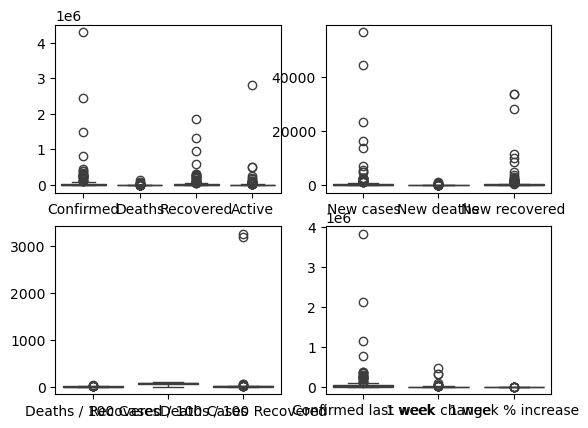

In [21]:
plt.subplot(2,2,1)
sns.boxplot(data= country_wise_df[col[0]])

plt.subplot(2,2,2)
sns.boxplot(data= country_wise_df[col[1]])

plt.subplot(2,2,3)
sns.boxplot(data= country_wise_df[col[2]])

plt.subplot(2,2,4)
sns.boxplot(data= country_wise_df[col[3]])
plt.show()

In [22]:
# confirmed column
lower,upper = calculating_iqr(country_wise_df,'Confirmed')
country_wise_df['Confirmed'] = country_wise_df['Confirmed'].apply(handle_outliers)

# Deaths column
lower,upper = calculating_iqr(country_wise_df,'Deaths')
country_wise_df['Deaths'] = country_wise_df['Deaths'].apply(handle_outliers)

# 'Recovered' column
lower,upper = calculating_iqr(country_wise_df,'Recovered')
country_wise_df['Recovered'] = country_wise_df['Recovered'].apply(handle_outliers)

# 'Active' column
lower,upper = calculating_iqr(country_wise_df,'Active')
country_wise_df['Active'] = country_wise_df['Active'].apply(handle_outliers)

##### Handling outliers in columns:  'Confirmed', 'Deaths','Recovered', 'Active'

In [26]:
# Handling 'New cases' column
lower,upper = calculating_iqr(country_wise_df,'New cases')
country_wise_df['New cases'] = country_wise_df['New cases'].apply(handle_outliers)

# Handling 'New deaths' column
lower,upper = calculating_iqr(country_wise_df,'New deaths')
country_wise_df['New deaths'] = country_wise_df['New deaths'].apply(handle_outliers)

# Handling 'New recovered' column
lower,upper = calculating_iqr(country_wise_df,'New recovered')
country_wise_df['New recovered'] = country_wise_df['New recovered'].apply(handle_outliers)

In [28]:
# 'Deaths / 100 Cases' column
lower,upper = calculating_iqr(country_wise_df,'Deaths / 100 Cases')
country_wise_df['Deaths / 100 Cases'] = country_wise_df['Deaths / 100 Cases'].apply(handle_outliers)
# 'Recovered / 100 Cases' column
lower,upper = calculating_iqr(country_wise_df,'Recovered / 100 Cases')
country_wise_df['Recovered / 100 Cases'] = country_wise_df['Recovered / 100 Cases'].apply(handle_outliers)
# 'Deaths / 100 Recovered' column
lower,upper = calculating_iqr(country_wise_df,'Deaths / 100 Recovered')
country_wise_df['Deaths / 100 Recovered'] = country_wise_df['Deaths / 100 Recovered'].apply(handle_outliers)

In [30]:
# 'Confirmed last week' column
lower,upper = calculating_iqr(country_wise_df,'Confirmed last week')
country_wise_df['Confirmed last week'] = country_wise_df['Confirmed last week'].apply(handle_outliers)

# '1 week change' column
lower,upper = calculating_iqr(country_wise_df,'1 week change')
country_wise_df['1 week change'] = country_wise_df['1 week change'].apply(handle_outliers)

# '1 week % increase' column
lower,upper = calculating_iqr(country_wise_df,'1 week % increase')
country_wise_df['1 week % increase'] = country_wise_df['1 week % increase'].apply(handle_outliers)

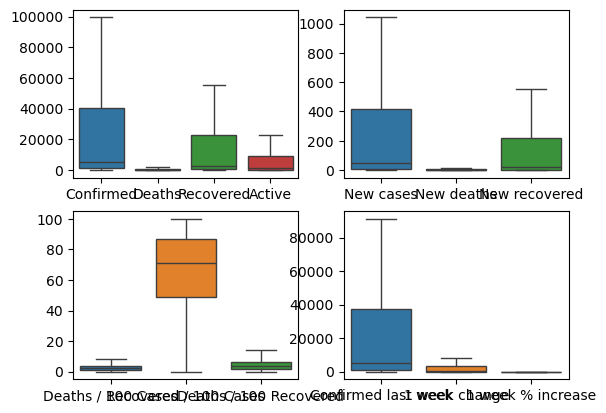

In [32]:
# Ploting after handling outliers
plt.subplot(2,2,1)
sns.boxplot(data= country_wise_df[col[0]])

plt.subplot(2,2,2)
sns.boxplot(data= country_wise_df[col[1]])

plt.subplot(2,2,3)
sns.boxplot(data= country_wise_df[col[2]])

plt.subplot(2,2,4)
sns.boxplot(data= country_wise_df[col[3]])
plt.show()

In [33]:
country_wise_df.describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,25944.139037,510.172460,14132.883690,6266.176471,264.544118,3.802139,144.483957,2.697005,64.820535,4.768289,23604.331551,2022.804813,11.167340
std,35481.834416,700.605387,19846.563715,8514.912668,366.343842,5.496665,205.116423,2.255514,26.287694,4.249337,32536.210181,2773.893022,10.918431
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-24.500000,-1.387500
25%,1114.000000,18.500000,626.500000,141.500000,4.000000,0.000000,0.000000,0.945000,48.770000,1.450000,1051.500000,49.000000,2.775000
50%,5059.000000,108.000000,2815.000000,1600.000000,49.000000,1.000000,22.000000,2.150000,71.320000,3.620000,5020.000000,432.000000,6.890000
75%,40460.500000,734.000000,22606.000000,9149.000000,419.500000,6.000000,221.000000,3.875000,86.885000,6.440000,37080.500000,3172.000000,16.855000
max,99480.250000,1807.250000,55575.250000,22660.250000,1042.750000,15.000000,552.500000,8.270000,100.000000,13.925000,91124.000000,7856.500000,37.975000


In [36]:
country_wise_df['Total cases'] = country_wise_df['Confirmed'] + country_wise_df['New cases']

In [38]:
country_wise_df['Total deaths'] = country_wise_df['Deaths'] + country_wise_df['New deaths']


In [40]:
country_wise_df['Total recovered'] = country_wise_df['Recovered'] + country_wise_df['New recovered']

In [42]:
country_wise_df['Total active'] = country_wise_df['Total cases'] - (country_wise_df['Total deaths'] + country_wise_df['Total recovered'])

In [44]:
country_wise_df['Active / 100 Cases'] = 100 - ( country_wise_df['Deaths / 100 Cases'] + country_wise_df['Recovered / 100 Cases'])

In [46]:
country_wise_df.head()

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region,Total cases,Total deaths,Total recovered,Total active,Active / 100 Cases
0,Afghanistan,36263.0,1269.0,25198.0,9796.0,106.0,10.0,18.0,3.50,69.49,5.040,35526.0,737.0,2.07,Eastern Mediterranean,36369.0,1279.0,25216.0,9874.0,27.01
1,Albania,4880.0,144.0,2745.0,1991.0,117.0,6.0,63.0,2.95,56.25,5.250,4171.0,709.0,17.00,Europe,4997.0,150.0,2808.0,2039.0,40.80
2,Algeria,27973.0,1163.0,18837.0,7973.0,616.0,8.0,552.5,4.16,67.34,6.170,23691.0,4282.0,18.07,Africa,28589.0,1171.0,19389.5,8028.5,28.50
3,Andorra,907.0,52.0,803.0,52.0,10.0,0.0,0.0,5.73,88.53,6.480,884.0,23.0,2.60,Europe,917.0,52.0,803.0,62.0,5.74
4,Angola,950.0,41.0,242.0,667.0,18.0,1.0,0.0,4.32,25.47,13.925,749.0,201.0,26.84,Africa,968.0,42.0,242.0,684.0,70.21


In [48]:
len(country_wise_df['Country/Region'].unique())

187

In [50]:
n_country_WHO = country_wise_df.groupby('WHO Region')['Country/Region'].count()
n_country_WHO

WHO Region
Africa                   48
Americas                 35
Eastern Mediterranean    22
Europe                   56
South-East Asia          10
Western Pacific          16
Name: Country/Region, dtype: int64

In [52]:
who_reg_val = country_wise_df['WHO Region'].unique()
who_reg_val

array(['Eastern Mediterranean', 'Europe', 'Africa', 'Americas',
       'Western Pacific', 'South-East Asia'], dtype=object)

In [54]:
max_countries_in_active_in_each_who_region = country_wise_df.groupby('WHO Region')['Country/Region'].agg({max_death := ('Total deaths',"max"), max_confirmed := ('Total cases','max'),max_recovered := ('Total recovered','max')})
max_countries_in_active_in_each_who_region

,Total deaths,Total recovered,Total cases
WHO Region,,,
Africa,Zimbabwe,Zimbabwe,Zimbabwe
Americas,Venezuela,Venezuela,Venezuela
Eastern Mediterranean,Yemen,Yemen,Yemen
Europe,Uzbekistan,Uzbekistan,Uzbekistan
South-East Asia,Timor-Leste,Timor-Leste,Timor-Leste
Western Pacific,Vietnam,Vietnam,Vietnam


In [56]:
max_countries_in_active_in_each_who_region_per = country_wise_df.groupby('WHO Region')['Country/Region'].agg({max_death_100_cases := ('Deaths / 100 Cases country',"max"), max_recover_100_cases := ('Recovered / 100 Cases country','max'),max_death_for_100_recover := ('Deaths / 100 Recovered country','max')})
max_countries_in_active_in_each_who_region_per

,Deaths / 100 Recovered country,Recovered / 100 Cases country,Deaths / 100 Cases country
WHO Region,,,
Africa,Zimbabwe,Zimbabwe,Zimbabwe
Americas,Venezuela,Venezuela,Venezuela
Eastern Mediterranean,Yemen,Yemen,Yemen
Europe,Uzbekistan,Uzbekistan,Uzbekistan
South-East Asia,Timor-Leste,Timor-Leste,Timor-Leste
Western Pacific,Vietnam,Vietnam,Vietnam


from this analysis we will find that for each 100 cases maximum values for each country in each WHO Region will be the same if they are compared between all cases without percentage

In [59]:
country_wise_df.columns

Index(['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered',
       'Confirmed last week', '1 week change', '1 week % increase',
       'WHO Region', 'Total cases', 'Total deaths', 'Total recovered',
       'Total active', 'Active / 100 Cases'],
      dtype='object')

In [61]:
country_wise_df[['Deaths / 100 Cases','Recovered / 100 Cases', 'Deaths / 100 Recovered','Confirmed last week', '1 week change', '1 week % increase', 'Total cases', 'Total deaths', 'Total recovered','Total active', 'Active / 100 Cases']].describe()

,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,Total cases,Total deaths,Total recovered,Total active,Active / 100 Cases
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,2.697005,64.820535,4.768289,23604.331551,2022.804813,11.167340,26208.683155,513.974599,14277.367647,11417.340909,32.482460
std,2.255514,26.287694,4.249337,32536.210181,2773.893022,10.918431,35786.844542,704.750409,20001.296949,18976.878127,26.042935
min,0.000000,0.000000,0.000000,10.000000,-24.500000,-1.387500,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.945000,48.770000,1.450000,1051.500000,49.000000,2.775000,1123.000000,18.500000,633.000000,146.000000,10.935000
50%,2.150000,71.320000,3.620000,5020.000000,432.000000,6.890000,5068.000000,108.000000,3016.000000,1647.000000,26.250000
75%,3.875000,86.885000,6.440000,37080.500000,3172.000000,16.855000,41017.000000,742.000000,22849.000000,10419.750000,48.085000
max,8.270000,100.000000,13.925000,91124.000000,7856.500000,37.975000,100523.000000,1822.250000,56127.750000,98344.000000,100.000000


## Plotting

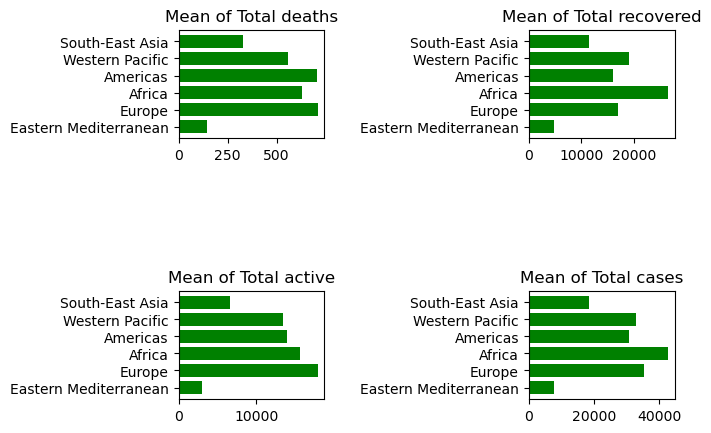

In [64]:
plt.subplot(3,3,1)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total deaths'].mean(),color = 'green')
plt.title('Mean of Total deaths')

plt.subplot(3,3,3)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total recovered'].mean(),color = 'green')
plt.title('Mean of Total recovered')

plt.subplot(3,3,7)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total active'].mean(),color = 'green')
plt.title('Mean of Total active')

plt.subplot(3,3,9)
plt.barh(who_reg_val,country_wise_df.groupby('WHO Region')['Total cases'].mean(),color = 'green')
plt.title('Mean of Total cases')

plt.show()

####  From previous calculations we will find out that highest WHO Region in 

##### 'Total cases' of Covid 19
1. Africa
2. Europe
#####  'Total active'
1. Europe
2. Africa
##### 'Total recovered'
1. Europe
2. Western Pacific
##### 'Total deaths'
1. Europe
2. Americans

In [67]:
#countries =  max_countries_in_active_in_each_who_region.loc[:,'Total recovered']
countries = list(x for x in max_countries_in_active_in_each_who_region["Total recovered"])
countries

['Zimbabwe', 'Venezuela', 'Yemen', 'Uzbekistan', 'Timor-Leste', 'Vietnam']

In [69]:
y = country_wise_df[ country_wise_df['Country/Region'].isin(countries)]

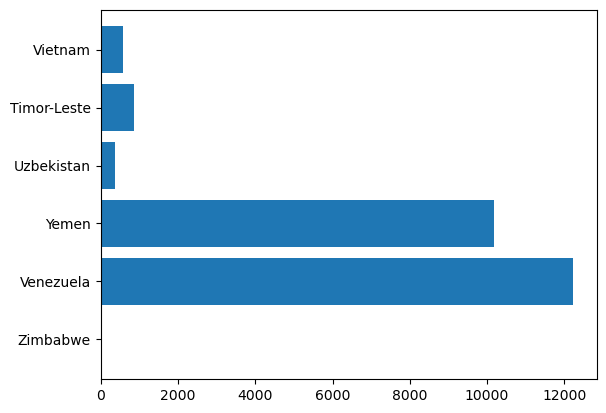

In [71]:
plt.barh(countries, y['Total recovered'])
plt.show()

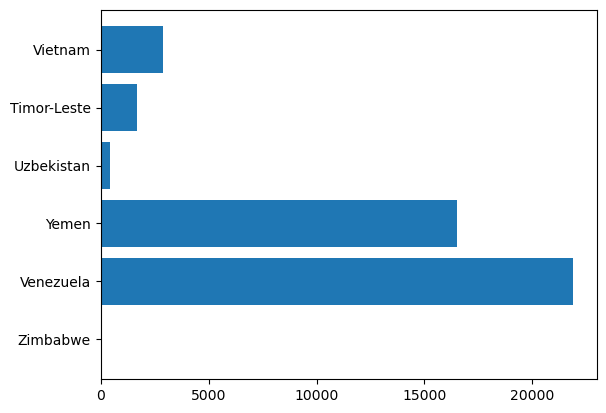

In [73]:
plt.barh(countries, y['Total cases'])
plt.show()

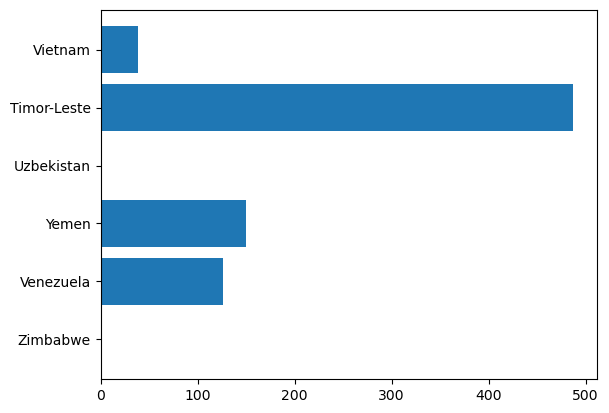

In [75]:
plt.barh(countries, y['Total deaths'])
plt.show()

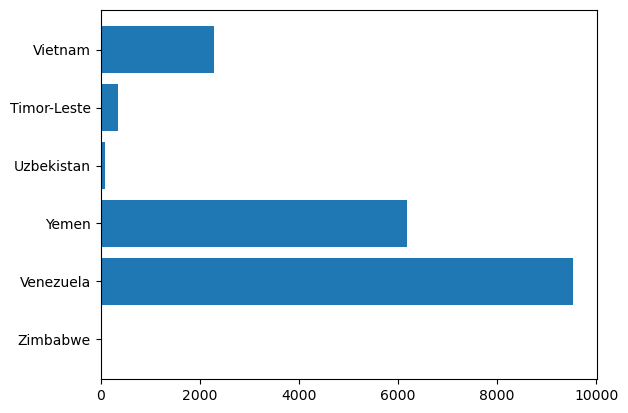

In [77]:
plt.barh(countries, y['Total active'])
plt.show()

#### From the previous analysis we get that for each WHO region has x countries and for the maximum value in each one:
##### for total recovered column
1. Venezuela
2. Yemen
3. Timor-Leste
4. Vietnam
5. Uzbekistan
6. Zimbabwe
##### for total cases column
1. Venezuela
2. Yemen
3. Vietnam
4. Timor-Leste
5. Uzbekistan
6. Zimbabwe
##### for Total deaths column
1. Timor-Leste
2. Yemen
3. Venezuela
4. Vietnam
5. Uzbekistan
6. Zimbabwe
##### for active column
1. Venezuela
2. Yemen
3. Vietnam
4. Timor-Leste
5. Uzbekistan
6. Zimbabwe


In [3]:
covid_19_clean_complete_df = pd.read_csv("covid_19_clean_complete.csv")

In [5]:
covid_19_clean_complete_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [7]:
covid_19_clean_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [9]:
row = covid_19_clean_complete_df.shape[0]
nu = covid_19_clean_complete_df['Province/State'].isnull().sum()
non_null = row - nu
percent_state = (non_null / row) * 100
percent_state

29.88505747126437

As the percentage of column Province/State is 29% then it is best to drop the column

In [12]:
covid_19_clean_complete_df = covid_19_clean_complete_df.drop(columns = ['Province/State'])

In [14]:
covid_19_clean_complete_df.columns

Index(['Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'WHO Region'],
      dtype='object')

In [30]:
covid_19_clean_complete_df.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Month,Day
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,1,22
1,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe,1,22
2,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa,1,22
3,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe,1,22
4,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa,1,22


In [18]:
covid_19_clean_complete_df.tail()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
49063,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe
49067,Lesotho,-29.610000,28.233600,2020-07-27,505,12,128,365,Africa


In [20]:
covid_19_clean_complete_df['Date'] = pd.to_datetime(covid_19_clean_complete_df['Date'])

In [22]:
covid_19_clean_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  49068 non-null  object        
 1   Lat             49068 non-null  float64       
 2   Long            49068 non-null  float64       
 3   Date            49068 non-null  datetime64[ns]
 4   Confirmed       49068 non-null  int64         
 5   Deaths          49068 non-null  int64         
 6   Recovered       49068 non-null  int64         
 7   Active          49068 non-null  int64         
 8   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 3.4+ MB


In [24]:
covid_19_clean_complete_df['Month'] =  covid_19_clean_complete_df['Date'].dt.month

In [26]:
covid_19_clean_complete_df['Day'] =  covid_19_clean_complete_df['Date'].dt.day

In [28]:
covid_19_clean_complete_df.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region,Month,Day
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean,1,22
1,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe,1,22
2,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa,1,22
3,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe,1,22
4,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa,1,22


In [32]:
covid_19_clean_complete_df.describe()

,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Month,Day
count,49068.000000,49068.000000,49068,4.906800e+04,49068.000000,4.906800e+04,4.906800e+04,49068.000000,49068.000000
mean,21.433730,23.528236,2020-04-24 12:00:00,1.688490e+04,884.179160,7.915713e+03,8.085012e+03,4.281915,15.957447
min,-51.796300,-135.000000,2020-01-22 00:00:00,0.000000e+00,0.000000,0.000000e+00,-1.400000e+01,1.000000,1.000000
25%,7.873054,-15.310100,2020-03-08 18:00:00,4.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.000000,8.000000
50%,23.634500,21.745300,2020-04-24 12:00:00,1.680000e+02,2.000000,2.900000e+01,2.600000e+01,4.000000,16.000000
75%,41.204380,80.771797,2020-06-10 06:00:00,1.518250e+03,30.000000,6.660000e+02,6.060000e+02,6.000000,24.000000
max,71.706900,178.065000,2020-07-27 00:00:00,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,7.000000,31.000000
std,24.950320,70.442740,NaN,1.273002e+05,6313.584411,5.480092e+04,7.625890e+04,1.810241,8.770100


Plotting

In [ ]:
# Ploting after handling outliers
plt.subplot(2,2,1)
sns.boxplot(data= covid_19_clean_complete_df[col[0]])

plt.subplot(2,2,2)
sns.boxplot(data= covid_19_clean_complete_df[col[1]])

plt.subplot(2,2,3)
sns.boxplot(data= covid_19_clean_complete_df[col[2]])

plt.subplot(2,2,4)
sns.boxplot(data= covid_19_clean_complete_df[col[3]])
plt.show()

In [7]:
day_wise_df = pd.read_csv('day_wise.csv')

In [9]:
day_wise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    188 non-null    object 
 1   Confirmed               188 non-null    int64  
 2   Deaths                  188 non-null    int64  
 3   Recovered               188 non-null    int64  
 4   Active                  188 non-null    int64  
 5   New cases               188 non-null    int64  
 6   New deaths              188 non-null    int64  
 7   New recovered           188 non-null    int64  
 8   Deaths / 100 Cases      188 non-null    float64
 9   Recovered / 100 Cases   188 non-null    float64
 10  Deaths / 100 Recovered  188 non-null    float64
 11  No. of countries        188 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 17.8+ KB


In [11]:
day_wise_df['Date'] = pd.to_datetime(day_wise_df['Date'])

In [13]:
day_wise_df.head()

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13


In [15]:
day_wise_df['Date'].min()

Timestamp('2020-01-22 00:00:00')

In [17]:
day_wise_df['Date'].max()

Timestamp('2020-07-27 00:00:00')

In [19]:
col = day_wise_df.columns
col

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases',
       'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered', 'No. of countries'],
      dtype='object')

In [21]:
day_wise_df[col[1:]].describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
count,1.880000e+02,188.000000,1.880000e+02,1.880000e+02,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,4.406960e+06,230770.760638,2.066001e+06,2.110188e+06,87771.021277,3478.824468,50362.015957,4.860638,34.343936,22.104521,144.351064
std,4.757988e+06,217929.094183,2.627976e+06,1.969670e+06,75295.293255,2537.735652,56090.892479,1.579541,16.206159,22.568307,65.175979
min,5.550000e+02,17.000000,2.800000e+01,5.100000e+02,0.000000,0.000000,0.000000,2.040000,1.710000,6.260000,6.000000
25%,1.121910e+05,3935.000000,6.044125e+04,5.864175e+04,5568.500000,250.750000,2488.250000,3.510000,22.785000,9.650000,101.250000
50%,2.848733e+06,204190.000000,7.847840e+05,1.859759e+06,81114.000000,4116.000000,30991.500000,4.850000,35.680000,15.380000,184.000000
75%,7.422046e+06,418634.500000,3.416396e+06,3.587015e+06,131502.500000,5346.000000,79706.250000,6.297500,48.945000,25.342500,187.000000
max,1.648048e+07,654036.000000,9.468087e+06,6.358362e+06,282756.000000,9966.000000,284394.000000,7.180000,57.450000,134.430000,187.000000


In [23]:
col = [ ['Confirmed', 'Deaths', 'Recovered', 'Active'],[ 'New cases',
       'New deaths', 'New recovered'], ['Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered']]

<Axes: >

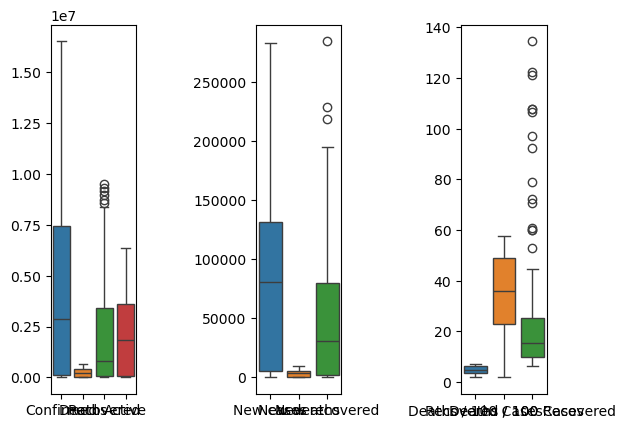

In [25]:
plt.subplot(1,5,1)
sns.boxplot(data= day_wise_df[col[0]])

plt.subplot(1,5,3)
sns.boxplot(data= day_wise_df[col[1]])

plt.subplot(1,5,5)
sns.boxplot(data= day_wise_df[col[2]])

In [27]:
lower,upper = calculating_iqr(day_wise_df,'Recovered')
day_wise_df['Recovered'] = day_wise_df['Recovered'].apply(handle_outliers)

lower,upper = calculating_iqr(day_wise_df,'New recovered')
day_wise_df['New recovered'] = day_wise_df['New recovered'].apply(handle_outliers)

lower,upper = calculating_iqr(day_wise_df,'Deaths / 100 Recovered')
day_wise_df['Deaths / 100 Recovered'] = day_wise_df['Deaths / 100 Recovered'].apply(handle_outliers)

<Axes: >

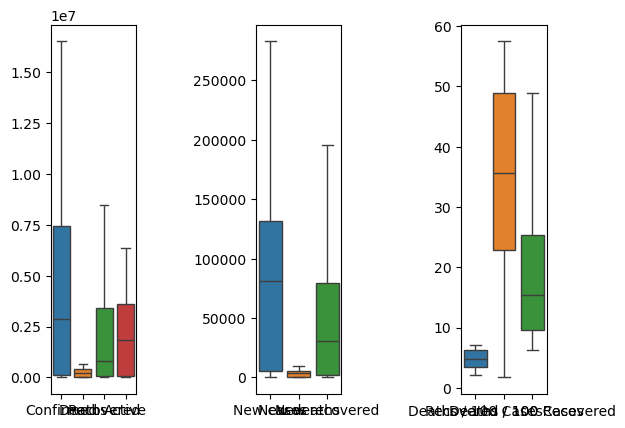

In [29]:
plt.subplot(1,5,1)
sns.boxplot(data= day_wise_df[col[0]])

plt.subplot(1,5,3)
sns.boxplot(data= day_wise_df[col[1]])

plt.subplot(1,5,5)
sns.boxplot(data= day_wise_df[col[2]])

In [51]:
day_wise_df['Total death'] = day_wise_df['Deaths'] + day_wise_df['New deaths']

In [53]:
day_wise_df['Total recovered'] = day_wise_df['Recovered'] + day_wise_df['New recovered']

In [55]:
day_wise_df['Total cases'] = day_wise_df['Confirmed'] + day_wise_df['New cases']

In [57]:
day_wise_df.columns

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases',
       'New deaths', 'New recovered', 'Deaths / 100 Cases',
       'Recovered / 100 Cases', 'Deaths / 100 Recovered', 'No. of countries',
       'Total cases', 'Total recovered', 'Total death'],
      dtype='object')

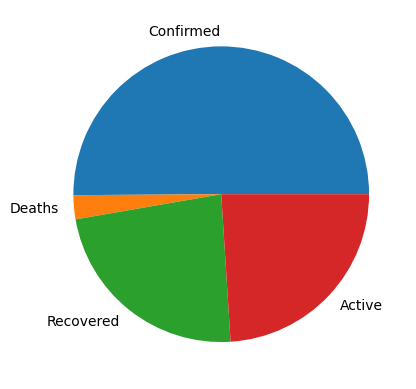

In [69]:
plt.pie(day_wise_df[col[0]].sum(),labels = col[0])
plt.show()

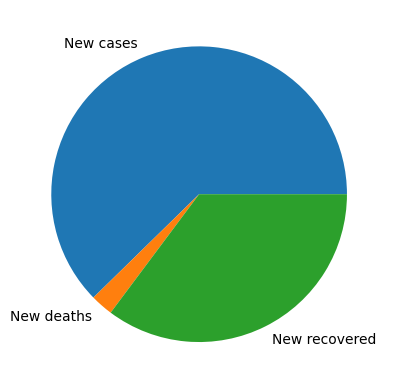

In [71]:
plt.pie(day_wise_df[col[1]].sum(),labels = col[1])
plt.show()

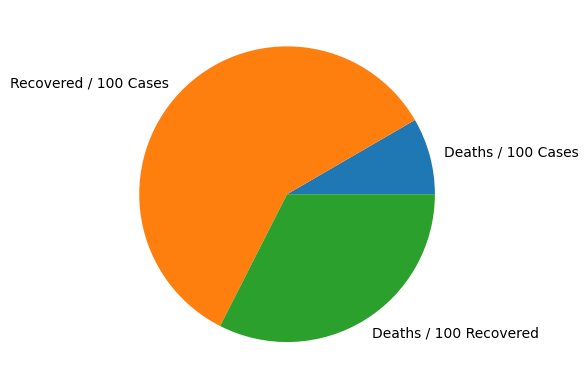

In [73]:
plt.pie(day_wise_df[col[2]].sum(),labels = col[2])
plt.show()

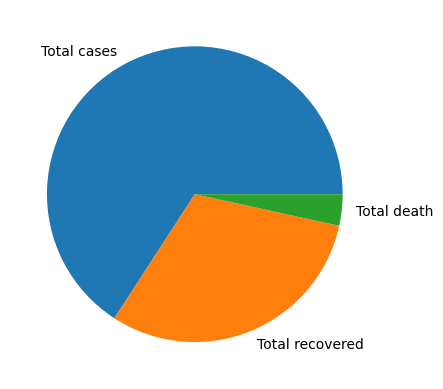

In [75]:
total = ['Total cases', 'Total recovered', 'Total death']
plt.pie(day_wise_df[total].sum(),labels = total)
plt.show()

Plotting

In [7]:
full_grouped_df = pd.read_csv('full_grouped.csv')

In [9]:
full_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            35156 non-null  object
 1   Country/Region  35156 non-null  object
 2   Confirmed       35156 non-null  int64 
 3   Deaths          35156 non-null  int64 
 4   Recovered       35156 non-null  int64 
 5   Active          35156 non-null  int64 
 6   New cases       35156 non-null  int64 
 7   New deaths      35156 non-null  int64 
 8   New recovered   35156 non-null  int64 
 9   WHO Region      35156 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.7+ MB


In [11]:
full_grouped_df['Date'] = pd.to_datetime(full_grouped_df['Date'])

In [13]:
full_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            35156 non-null  datetime64[ns]
 1   Country/Region  35156 non-null  object        
 2   Confirmed       35156 non-null  int64         
 3   Deaths          35156 non-null  int64         
 4   Recovered       35156 non-null  int64         
 5   Active          35156 non-null  int64         
 6   New cases       35156 non-null  int64         
 7   New deaths      35156 non-null  int64         
 8   New recovered   35156 non-null  int64         
 9   WHO Region      35156 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 2.7+ MB


In [15]:
full_grouped_df.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa


In [17]:
col = ['Confirmed',	'Deaths', 'Recovered', 'Active'	, 'New cases', 'New deaths', 'New recovered']
full_grouped_df[col].describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
count,3.515600e+04,35156.000000,3.515600e+04,3.515600e+04,35156.00000,35156.000000,35156.000000
mean,2.356663e+04,1234.068239,1.104813e+04,1.128443e+04,469.36375,18.603339,269.315593
std,1.499818e+05,7437.238354,6.454640e+04,8.997149e+04,3005.86754,115.706351,2068.063852
min,0.000000e+00,0.000000,0.000000e+00,-2.000000e+00,0.00000,-1918.000000,-16298.000000
25%,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000
50%,2.500000e+02,4.000000,3.300000e+01,8.500000e+01,2.00000,0.000000,0.000000
75%,3.640250e+03,78.250000,1.286250e+03,1.454000e+03,75.00000,1.000000,20.000000
max,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,77255.00000,3887.000000,140050.000000


In [19]:
full_grouped_df[full_grouped_df['New deaths']<0].count()

Date              38
Country/Region    38
Confirmed         38
Deaths            38
Recovered         38
Active            38
New cases         38
New deaths        38
New recovered     38
WHO Region        38
dtype: int64

In [21]:
# as there should be no negative values in deaths,recovered values then we are gonna to drop and if the percentage of them is big then we can get their abs val for them 
cond = (full_grouped_df['New deaths'] >= 0) & (full_grouped_df['Active'] >= 0) & (full_grouped_df['New recovered'] >= 0)
new_data = full_grouped_df[cond].copy()

In [23]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35041 entries, 0 to 35155
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            35041 non-null  datetime64[ns]
 1   Country/Region  35041 non-null  object        
 2   Confirmed       35041 non-null  int64         
 3   Deaths          35041 non-null  int64         
 4   Recovered       35041 non-null  int64         
 5   Active          35041 non-null  int64         
 6   New cases       35041 non-null  int64         
 7   New deaths      35041 non-null  int64         
 8   New recovered   35041 non-null  int64         
 9   WHO Region      35041 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 2.9+ MB


In [25]:
new_data.shape

(35041, 10)

In [27]:
percentage = (new_data.shape[0] / full_grouped_df.shape[0]) * 100
percentage

99.67288656274889

In [29]:
new_data[col].describe()

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
count,3.504100e+04,35041.000000,3.504100e+04,3.504100e+04,35041.000000,35041.000000,35041.000000
mean,2.351692e+04,1227.798493,1.103168e+04,1.125744e+04,469.348906,18.590508,271.163808
std,1.500045e+05,7423.438095,6.459747e+04,8.992780e+04,3008.153287,114.807722,2067.557128
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,2.460000e+02,4.000000,3.300000e+01,8.400000e+01,2.000000,0.000000,0.000000
75%,3.623000e+03,78.000000,1.279000e+03,1.454000e+03,74.000000,1.000000,20.000000
max,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06,77255.000000,3887.000000,140050.000000


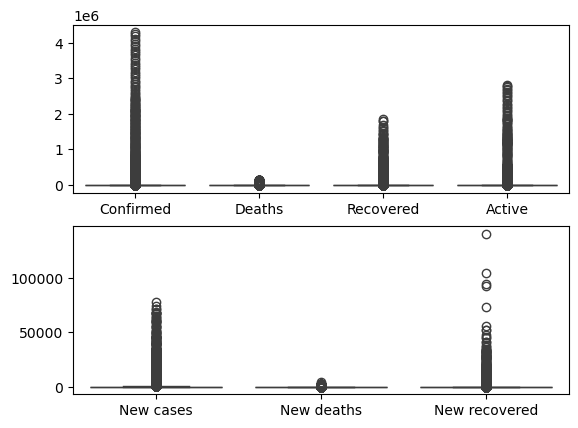

In [31]:
plt.subplot(2,1,1)
sns.boxplot(data= new_data[col[:4]])

plt.subplot(2,1,2)
sns.boxplot(data= new_data[col[-3:]])

plt.show()

In [32]:
for i in col:
    lower,upper = calculating_iqr(new_data,i)
    new_data[i] = new_data[i].apply(handle_outliers)

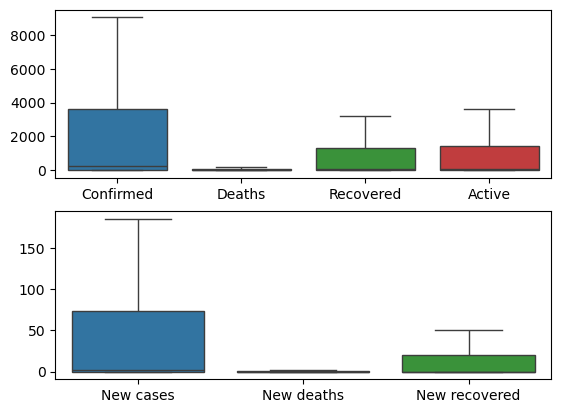

In [35]:
plt.subplot(2,1,1)
sns.boxplot(data= new_data[col[:4]])

plt.subplot(2,1,2)
sns.boxplot(data= new_data[col[-3:]])

plt.show()

In [39]:
new_data.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Eastern Mediterranean
1,2020-01-22,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Europe
2,2020-01-22,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa
3,2020-01-22,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Europe
4,2020-01-22,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Africa


In [41]:
new_data.tail()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
35151,2020-07-27,West Bank and Gaza,9056.0,78.0,3197.5,3635.0,152.0,2.0,0.0,Eastern Mediterranean
35152,2020-07-27,Western Sahara,10.0,1.0,8.0,1.0,0.0,0.0,0.0,Africa
35153,2020-07-27,Yemen,1691.0,195.0,833.0,375.0,10.0,2.5,36.0,Eastern Mediterranean
35154,2020-07-27,Zambia,4552.0,140.0,2815.0,1597.0,71.0,1.0,50.0,Africa
35155,2020-07-27,Zimbabwe,2704.0,36.0,542.0,2126.0,185.0,2.0,24.0,Africa


In [43]:
new_data['Total death'] = new_data['Deaths'] + new_data['New deaths']

In [45]:
new_data['Total recovered'] = new_data['Recovered'] + new_data['New recovered']

In [47]:
new_data['Total cases'] = new_data['Confirmed'] + new_data['New cases']

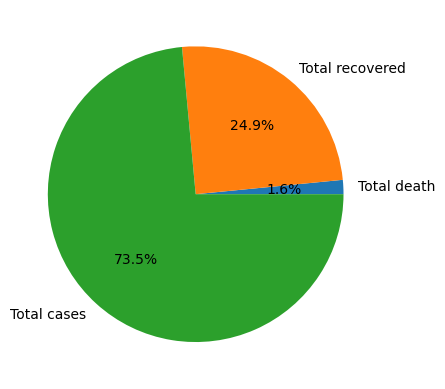

In [51]:
total = ['Total death', 'Total recovered', 'Total cases']
plt.pie(new_data[total].sum(),labels = total,autopct = '%1.1F%%')
plt.show()

In [63]:
new_data['WHO Region'].unique()

array(['Eastern Mediterranean', 'Europe', 'Africa', 'Americas',
       'Western Pacific', 'South-East Asia'], dtype=object)

In [93]:
Total_cases_mean = new_data.groupby('WHO Region')['Total cases'].mean()
Total_cases_mean

WHO Region
Africa                   1046.708532
Americas                 2336.305877
Eastern Mediterranean    3084.405667
Europe                   3381.282054
South-East Asia          2206.663292
Western Pacific          2709.891486
Name: Total cases, dtype: float64

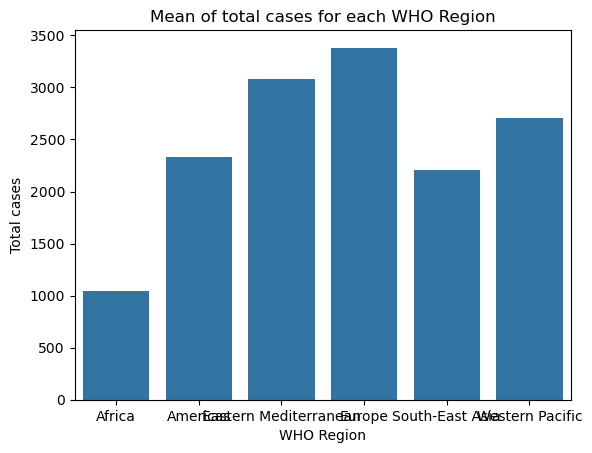

In [111]:
sns.barplot(x = Total_cases_mean.index,y = Total_cases_mean.values )
plt.title('Mean of total cases for each WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Total cases')
plt.show()

In [99]:
Total_death_mean = new_data.groupby('WHO Region')['Total death'].mean()
Total_death_mean

WHO Region
Africa                   21.480972
Americas                 51.897762
Eastern Mediterranean    61.527610
Europe                   75.822832
South-East Asia          41.115344
Western Pacific          45.995993
Name: Total death, dtype: float64

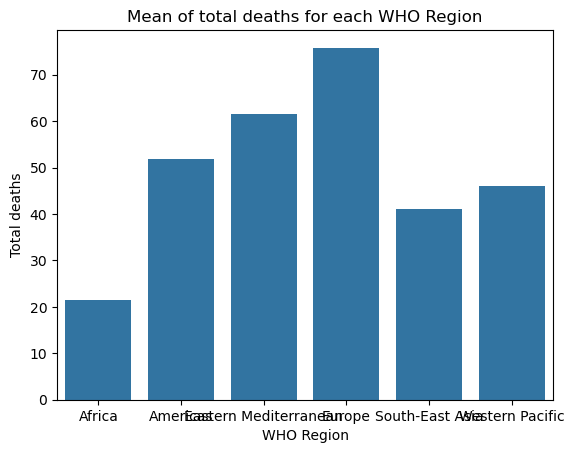

In [101]:

sns.barplot(x = Total_death_mean.index,y = Total_death_mean.values )
plt.title('Mean of total deaths for each WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Total deaths')
plt.show()

In [105]:
Total_recovered_mean = new_data.groupby('WHO Region')['Total recovered'].mean()
Total_recovered_mean

WHO Region
Africa                    397.985188
Americas                  711.464753
Eastern Mediterranean    1063.043957
Europe                   1125.405153
South-East Asia           848.151305
Western Pacific           951.948748
Name: Total recovered, dtype: float64

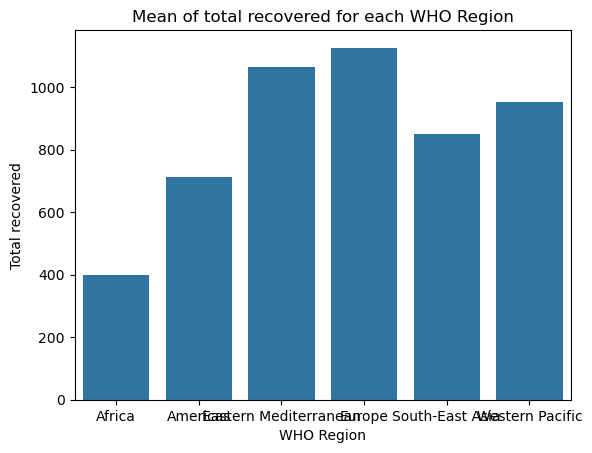

In [107]:

sns.barplot(x = Total_recovered_mean.index,y = Total_recovered_mean.values )
plt.title('Mean of total recovered for each WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Total recovered')
plt.show()

From previous analysis we will find that:

In [113]:
usa_county_wise_df = pd.read_csv('usa_county_wise.csv')

In [117]:
usa_county_wise_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",1/22/20,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",1/22/20,0,0
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",1/22/20,0,0
3,63072001,PR,PRI,630,72001.0,Adjuntas,Puerto Rico,US,18.180117,-66.754367,"Adjuntas, Puerto Rico, US",1/22/20,0,0
4,63072003,PR,PRI,630,72003.0,Aguada,Puerto Rico,US,18.360255,-67.175131,"Aguada, Puerto Rico, US",1/22/20,0,0


In [115]:
usa_county_wise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627920 entries, 0 to 627919
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UID             627920 non-null  int64  
 1   iso2            627920 non-null  object 
 2   iso3            627920 non-null  object 
 3   code3           627920 non-null  int64  
 4   FIPS            626040 non-null  float64
 5   Admin2          626792 non-null  object 
 6   Province_State  627920 non-null  object 
 7   Country_Region  627920 non-null  object 
 8   Lat             627920 non-null  float64
 9   Long_           627920 non-null  float64
 10  Combined_Key    627920 non-null  object 
 11  Date            627920 non-null  object 
 12  Confirmed       627920 non-null  int64  
 13  Deaths          627920 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 67.1+ MB


In [125]:
usa_county_wise_df.drop('Admin2',axis = 1,inplace  = True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%y')

In [ ]:
worldometer_data_df = pd.read_csv('worldometer_data.csv')